## Load Data and Prepare Features
Load train and validation splits, extract features and targets, and handle missing values using median.


In [29]:
# ============================================================================
# Load Data and Prepare Features
# ============================================================================

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

# Load train and validation splits produced by preprocessing_v2
df_train = pd.read_csv("data/splits/train.csv")
df_val   = pd.read_csv("data/splits/val.csv")

print("Train shape:", df_train.shape)
print("Val shape:", df_val.shape)
df_train.head()

Train shape: (64, 67)
Val shape: (14, 67)


,flightDate_month_day,is_weekend,is_public_holiday,days_from_summer_start,day_of_month,1 days to departure,2 days to departure,3 days to departure,4 days to departure,5 days to departure,...,53 days to departure,54 days to departure,55 days to departure,56 days to departure,57 days to departure,58 days to departure,59 days to departure,60 days to departure,flight_day_of_week,flight_month
0,07-02,0.088738,0.0,0.976123,0.177477,832.672129,905.357400,848.978187,847.358852,872.219924,...,468.140550,473.778344,478.916778,482.020238,482.762680,479.811067,478.248556,474.987407,0.073949,0.048403
1,08-17,0.000000,0.0,0.958218,0.285784,502.239731,489.446985,487.043378,465.364747,458.285406,...,531.688033,531.473628,530.756731,527.287056,523.771649,520.210510,518.429940,516.603638,0.005604,0.010698
2,06-10,0.000000,0.0,-0.738853,0.671684,1153.874722,1285.706208,1235.357662,1400.914128,1426.922385,...,422.064227,419.657468,417.803887,416.877097,416.877097,416.877097,416.877097,416.877097,0.044779,0.030531
3,08-10,0.000000,0.0,0.980483,0.196097,442.049211,438.842287,443.648173,425.654978,415.306457,...,502.611763,500.607187,499.435720,497.029930,495.161812,497.299294,498.521845,501.960460,0.006537,0.012479
4,06-06,0.000000,0.0,-0.928109,0.371244,546.352317,547.226353,549.062051,543.788650,535.464841,...,398.401143,398.401143,398.401143,398.401143,398.401143,398.401143,398.401143,398.401143,0.000000,0.028125


In [34]:
# ============================================================================
# Define Feature Columns and Target Columns
# ============================================================================

# Final feature set from preprocessing_v2 (V7 pipeline)
feature_cols = [
    "day_of_month",
    "is_weekend",
    "is_public_holiday",
    "days_from_summer_start",
    "flight_day_of_week",
    "flight_month",
]

# All days-to-departure columns (60 outputs)
target_cols = [c for c in df_train.columns if "days to departure" in c]
target_cols = sorted(target_cols, key=lambda x: int(x.split()[0]))

print("Number of target columns:", len(target_cols))
print("Example target cols:", target_cols[:5])

# Build X and y
X_train = df_train[feature_cols].values
X_val   = df_val[feature_cols].values

y_train = df_train[target_cols].values
y_val   = df_val[target_cols].values

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Safety: handle any remaining missing values in targets
imputer = SimpleImputer(strategy="median")
y_train = imputer.fit_transform(y_train)
y_val   = imputer.transform(y_val)

Number of target columns: 60
Example target cols: ['1 days to departure', '2 days to departure', '3 days to departure', '4 days to departure', '5 days to departure']
X_train shape: (64, 6)
y_train shape: (64, 60)
X_val shape: (14, 6)
y_val shape: (14, 60)


## Train Model
Train a XGBoost regression model to predict flight prices for all 60 days-to-departure horizons.


In [35]:
# ============================================================================
# Train Multi-Output XGBoost Model
# ============================================================================

base_model = XGBRegressor(
    max_depth=100,
    learning_rate=0.001,
    n_estimators=600,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

model = MultiOutputRegressor(base_model)

print("Training model...")
model.fit(X_train, y_train)
print("Training completed.")

# Predict on validation set
y_val_pred = model.predict(X_val)
print("Prediction completed.")

Training model...
Training completed.
Prediction completed.


## Evaluate and Visualize Results
Calculate MAE metrics and create visualizations comparing predictions to ground truth across different days-to-departures.



PREDICTION COMPARISON SUMMARY

Overall MAE: 61.72
Total predictions: 840
Number of samples: 14
Outputs per sample: 60

First rows:
    sample_idx  days_to_departure      actual   predicted  absolute_error
0            0                  1  482.220632  539.257385       57.036754
1            0                  2  450.498510  539.638123       89.139613
2            0                  3  438.754291  539.211121      100.456829
3            0                  4  452.747970  542.382263       89.634293
4            0                  5  455.068126  545.729431       90.661305
5            0                  6  460.148541  547.477173       87.328632
6            0                  7  489.979531  549.784241       59.804709
7            0                  8  512.223577  549.865967       37.642390
8            0                  9  493.954358  551.427185       57.472827
9            0                 10  487.194303  549.187378       61.993075
10           0                 11  473.013909  552.851

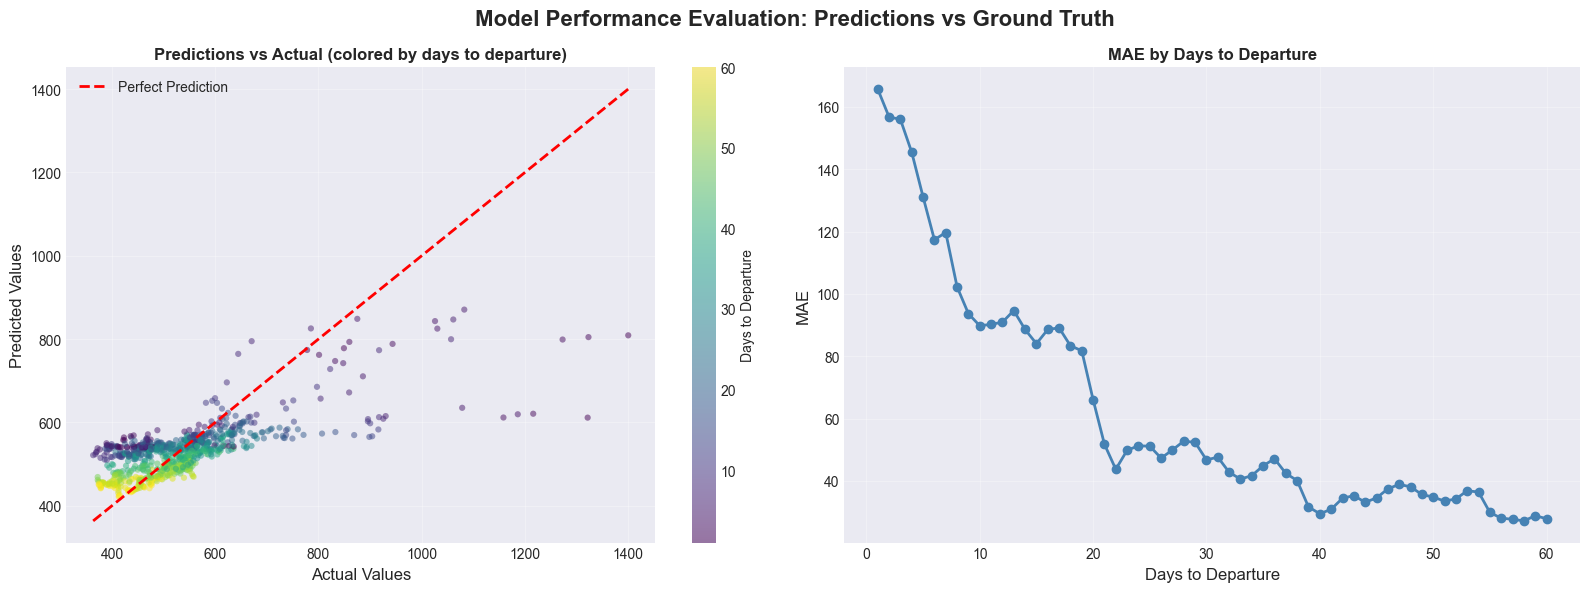

In [36]:
# ============================================================================
# Model Evaluation Visualizations
# ============================================================================

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('ggplot')
sns.set_palette("husl")

# Flatten predictions and actuals for comparison DataFrame
n_samples, n_outputs = y_val.shape
comparison_data = []

for sample_idx in range(n_samples):
    for output_idx in range(n_outputs):
        actual = y_val[sample_idx, output_idx]
        predicted = y_val_pred[sample_idx, output_idx]
        abs_error = abs(actual - predicted)

        days_to_departure = int(target_cols[output_idx].split()[0])

        comparison_data.append({
            "sample_idx": sample_idx,
            "days_to_departure": days_to_departure,
            "actual": actual,
            "predicted": predicted,
            "absolute_error": abs_error
        })

comparison_df = pd.DataFrame(comparison_data)

# Summary statistics
print("\n" + "="*80)
print("PREDICTION COMPARISON SUMMARY")
print("="*80)

mae_per_output = [
    mean_absolute_error(y_val[:, i], y_val_pred[:, i])
    for i in range(n_outputs)
]

overall_mae = mean_absolute_error(y_val, y_val_pred)

print(f"\nOverall MAE: {overall_mae:.2f}")
print(f"Total predictions: {len(comparison_df)}")
print(f"Number of samples: {n_samples}")
print(f"Outputs per sample: {n_outputs}")
print("\nFirst rows:")
print(comparison_df.head(20))

# ============================================================================
# Visualizations: Predictions vs Actual and MAE by Days to Departure
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Evaluation: Predictions vs Ground Truth',
             fontsize=16, fontweight='bold')

# -------------------------------------------------------------
# Plot 1: Scatter Plot - Predictions vs Actual
# -------------------------------------------------------------

ax1 = axes[0]
scatter = ax1.scatter(
    comparison_df['actual'],
    comparison_df['predicted'],
    alpha=0.5,
    s=20,
    c=comparison_df['days_to_departure'],
    cmap='viridis',
    edgecolors='none'
)

min_val = min(comparison_df['actual'].min(), comparison_df['predicted'].min())
max_val = max(comparison_df['actual'].max(), comparison_df['predicted'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

ax1.set_xlabel('Actual Values', fontsize=12)
ax1.set_ylabel('Predicted Values', fontsize=12)
ax1.set_title('Predictions vs Actual (colored by days to departure)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Days to Departure')

# -------------------------------------------------------------
# Plot 2: MAE by Days to Departure
# -------------------------------------------------------------

ax2 = axes[1]
days_list = [int(col.split()[0]) for col in target_cols]

ax2.plot(days_list, mae_per_output, marker='o', linewidth=2, markersize=6, color='steelblue')
ax2.set_xlabel('Days to Departure', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('MAE by Days to Departure', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 61, 10))

plt.tight_layout()
plt.show()